{'city': 'Pune', 'main': 'Clouds', 'temp': 22.810000000000002, 'feels_like': 22.970000000000027, 'temp_in_F': 295.96, 'timestamp': datetime.datetime(2024, 10, 27, 17, 1, 23)}
None
        city  avg_temp  max_temp  min_temp dominant_condition  timestamp
0  Bangalore     22.02     22.02     22.02               Haze 2024-10-27
1    Chennai     29.51     29.51     29.51               Haze 2024-10-27
2      Delhi     26.05     26.05     26.05               Haze 2024-10-27
3  Hyderabad     23.73     23.73     23.73               Haze 2024-10-27
4    Kolkata     27.97     27.97     27.97               Haze 2024-10-27
5     Mumbai     29.99     29.99     29.99               Haze 2024-10-27
        city  avg_temp  max_temp  min_temp dominant_condition  \
0  Bangalore     22.02     22.02     22.02               Haze   
1    Chennai     29.51     29.51     29.51               Haze   
2      Delhi     26.05     26.05     26.05               Haze   
3  Hyderabad     23.73     23.73     23.73       

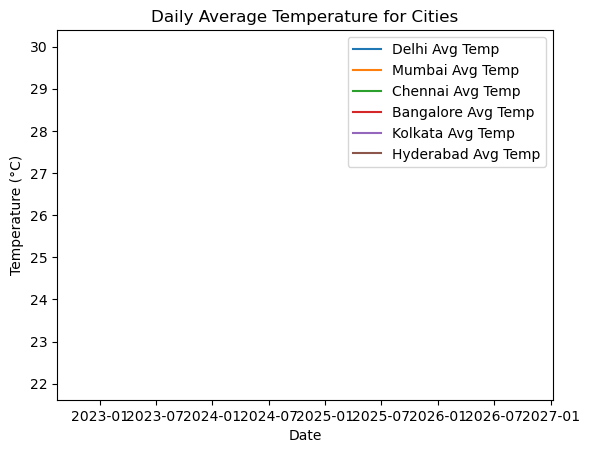

None


In [ ]:
import requests
import time
import pandas as pd
import sqlite3
import smtplib
from datetime import datetime, timedelta
from email.mime.text import MIMEText
import matplotlib.pyplot as plt

API_KEY = '82ff550e432791a03e7b75ca211e3c77'
CITIES = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']
API_URL = 'http://api.openweathermap.org/data/2.5/weather'
THRESHOLD_TEMP = 35  # Temperature threshold in Celsius for alerting
ALERT_DURATION = 2  # Consecutive updates required to trigger alert
DB_PATH = 'weather_data.db'

# Fetches the weather data from the API
def get_weather_data(city):
    params = {'q': city, 'appid': API_KEY}
    response = requests.get(API_URL, params=params)
    data = response.json()
    if response.status_code == 200:
        return {
            'city': city,
            'main': data['weather'][0]['main'],
            'temp': data['main']['temp'] - 273.15,  # Convert Kelvin to Celsius
            'feels_like': data['main']['feels_like'] - 273.15,
            'temp_in_F': data['main']['temp'],
            'timestamp': datetime.utcfromtimestamp(data['dt'])
        }
    else:
        print(f"Error fetching data for {city}: {data['message']}")
        return None

# Stores daily summary in SQLite database
def store_daily_summary(daily_data):
    with sqlite3.connect(DB_PATH) as conn:
        daily_data.to_sql('weather_summary', conn, if_exists='replace', index=False)

# Calculates daily summary for average, max, min temp, and dominant weather condition
def calculate_daily_summary(weather_data):
    df = pd.DataFrame(weather_data)
    daily_summary = df.groupby('city').agg(
        avg_temp=('temp', 'mean'),
        max_temp=('temp', 'max'),
        min_temp=('temp', 'min'),
        dominant_condition=('main', lambda x: x.mode()[0])
    ).reset_index()
    daily_summary['timestamp'] = pd.to_datetime('today').normalize()  # Add today's date
    return daily_summary


alert_streak = {city: 0 for city in CITIES}  # Track consecutive alerts

# Checks if thresholds are breached and triggers an alert if needed

def check_alerts(weather_data):
    for data in weather_data:
        city = data['city']
        if data['temp'] > THRESHOLD_TEMP:
            alert_streak[city] += 1
            if alert_streak[city] >= ALERT_DURATION:
                send_alert_email(city, data['temp'])
                alert_streak[city] = 0  # Reset streak after alert
        else:
            alert_streak[city] = 0

# Sends email alerts
def send_alert_email(city, temp):
    sender_email = 'sahilpawale444@gmail.com'
    receiver_email = 'sahil.ganpat2020@vitbhopal.ac.in'
    msg = MIMEText(f"Alert! Temperature in {city} has exceeded {THRESHOLD_TEMP}°C.\nCurrent Temperature: {temp}°C")
    msg['Subject'] = f"Weather Alert for {city}"
    msg['From'] = sender_email
    msg['To'] = receiver_email

    with smtplib.SMTP('smtp.gmail.com', 587) as server:
        server.starttls()
        server.login(sender_email, 'Sahil444')
        server.sendmail(sender_email, receiver_email, msg.as_string())
        print(f"Alert sent for {city}")


# Visualizes daily average temperatures for each city
def visualize_data():
    with sqlite3.connect(DB_PATH) as conn:
        df = pd.read_sql('SELECT * FROM weather_summary', conn)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    for city in CITIES:
        city_data = df[df['city'] == city]
        plt.plot(city_data['timestamp'], city_data['avg_temp'], label=f'{city} Avg Temp')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Daily Average Temperature for Cities')
    plt.legend()
    plt.show()

# Runs the weather monitoring system with specified intervals
def run_weather_monitoring(interval_minutes=5):
    weather_data = []
    while True:
        for city in CITIES:
            data = get_weather_data(city)
            if data:
                weather_data.append(data)
        daily_summary = calculate_daily_summary(weather_data)
        store_daily_summary(daily_summary)
        check_alerts(weather_data)
        weather_data.clear()  # Reset for the next interval
        time.sleep(interval_minutes * 60)  # Wait for the configured interval

# User can input a city to retrieve and view its data as well as visualize it
city = input("Enter the city : ")
weather_data = [get_weather_data(city) for city in CITIES if get_weather_data(city) is not None]
daily_data = calculate_daily_summary(weather_data)
store_daily_summary(daily_data)

print(get_weather_data(city))
print(store_daily_summary(daily_data))
print(calculate_daily_summary(weather_data))
# print(check_alerts(weather_data))
# print(send_alert_email(city, THRESHOLD_TEMP))
print(visualize_data())
print(run_weather_monitoring(interval_minutes=2))
